In [48]:
import pandas as pd
# Load the data
train_data = pd.read_csv(r"data_train.csv")
dev_data = pd.read_csv(r"data_dev.csv")
test_data = pd.read_csv(r"data_test.csv")

In [49]:
train_data.value_counts('label')

,count
label,
O,20084
I,3410
B,3248


In [50]:
dev_data.value_counts('label')

,count
label,
O,2499
I,399
B,394


In [51]:
test_data.value_counts('label')

,count
label,
O,2972
I,482
B,445


In [52]:
import pandas as pd

def calculate_average_length(file_path):
    # Load the data
    data = pd.read_csv(file_path)

    # Ensure columns are present
    assert 'token' in data.columns, "The file must contain a 'token' column."
    assert 'label' in data.columns, "The file must contain a 'label' column."

    # List to store sentence lengths
    sentence_lengths = []
    current_sentence = []

    # Sentence-ending punctuation
    sentence_endings = [".", "!", "?"]

    for token in data['token']:
        current_sentence.append(token)
        if token in sentence_endings:
            sentence_lengths.append(len(current_sentence))  # Add sentence length
            current_sentence = []  # Start a new sentence

    # If there's a trailing sentence without an ending punctuation
    if current_sentence:
        sentence_lengths.append(len(current_sentence))

    # Calculate the average length
    average_length = sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0
    return average_length

# Paths to the CSV files
train_file = "data_train.csv"
dev_file = "data_dev.csv"
test_file = "data_test.csv"

# Calculate average lengths
train_avg_length = calculate_average_length(train_file)
dev_avg_length = calculate_average_length(dev_file)
test_avg_length = calculate_average_length(test_file)

print(f"Average sentence length in train.csv: {train_avg_length:.2f} tokens")
print(f"Average sentence length in dev.csv: {dev_avg_length:.2f} tokens")
print(f"Average sentence length in test.csv: {test_avg_length:.2f} tokens")

Average sentence length in train.csv: 28.66 tokens
Average sentence length in dev.csv: 27.90 tokens
Average sentence length in test.csv: 28.88 tokens


In [53]:
import pandas as pd

def prepare_data_with_token_limit(df, max_tokens):
    """
    Groups tokens and labels into sentences with a maximum token limit,
    ensuring no sentence ends with an incomplete entity.

    Args:
        df (pd.DataFrame): Dataframe with columns 'token', 'label', and 'token length'.
        max_tokens (int): Maximum number of tokens allowed in a sentence.

    Returns:
        sentences (list of list of str): List of tokenized sentences.
        labels (list of list of str): List of BIO-tagged label sequences.
    """
    sentences = []
    labels = []
    current_sentence = []
    current_labels = []

    for i, row in df.iterrows():
        token, label = row["token"], row["label"]

        # Add token and label to the current sentence
        current_sentence.append(token)
        current_labels.append(label)

        # Check if we reached the max token limit
        if len(current_sentence) >= max_tokens:
            # Check if the last token ends with 'B' or 'I'
            if label.startswith("I") or label.startswith("B"):
                # Add the next token to complete the entity (if available)
                if i + 1 < len(df):
                    next_row = df.iloc[i + 1]
                    current_sentence.append(next_row["token"])
                    current_labels.append(next_row["label"])

            # Save the current sentence and reset
            sentences.append(current_sentence)
            labels.append(current_labels)
            current_sentence = []
            current_labels = []

    # Add the last sentence if present
    if current_sentence:
        sentences.append(current_sentence)
        labels.append(current_labels)

    return sentences, labels

# Example usage
train_data = pd.read_csv("data_train.csv")
max_tokens = 30  # Define your max token limit
train_sentences, train_labels = prepare_data_with_token_limit(train_data, max_tokens)

# Display the first few sentences and labels
print("First sentence tokens:", train_sentences[0])
print("First sentence labels:", train_labels[0])


First sentence tokens: ['In', 'this', 'article', 'we', 'discuss', 'several', 'metrics', 'of', 'coherence', 'defined', 'using', 'centering', 'theory', 'and', 'investigate', 'the', 'usefulness', 'of', 'such', 'metrics', 'for', 'information', 'ordering', 'in', 'automatic', 'text', 'generation', '.', 'We', 'estimate']
First sentence labels: ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O']


In [54]:
dev_sentences, dev_labels = prepare_data_with_token_limit(dev_data, max_tokens)
test_sentences, test_labels = prepare_data_with_token_limit(test_data, max_tokens)

In [55]:
print(len(train_sentences))
print(len(dev_sentences))
print(len(test_sentences))

892
110
130


In [56]:
unique_labels = sorted(set(label for labels in train_labels for label in labels))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# LSTM

In [57]:
import pandas as pd

def prepare_data_with_token_limit(df, max_tokens):
    """
    Groups tokens and labels into sentences with a maximum token limit,
    ensuring no sentence ends with an incomplete entity.

    Args:
        df (pd.DataFrame): Dataframe with columns 'token', 'label', and 'token length'.
        max_tokens (int): Maximum number of tokens allowed in a sentence.

    Returns:
        sentences (list of list of str): List of tokenized sentences.
        labels (list of list of str): List of BIO-tagged label sequences.
    """
    sentences = []
    labels = []
    current_sentence = []
    current_labels = []

    for i, row in df.iterrows():
        token, label = row["token"], row["label"]

        # Add token and label to the current sentence
        current_sentence.append(token)
        current_labels.append(label)

        # Check if we reached the max token limit or it's the last token
        if len(current_sentence) >= max_tokens or i == len(df) - 1:
            # Check if the last token ends with 'B' or 'I' and it's not the last token in the dataframe
            if (label.startswith("I") or label.startswith("B")) and i < len(df) - 1:
                # Add the next token to complete the entity (if available)
                next_row = df.iloc[i + 1]
                # Only add the next token if it doesn't exceed the max_tokens limit
                if len(current_sentence) + 1 <= max_tokens:
                    current_sentence.append(next_row["token"])
                    current_labels.append(next_row["label"])

            # Save the current sentence and reset
            sentences.append(current_sentence)
            labels.append(current_labels)
            current_sentence = []
            current_labels = []

    return sentences, labels

In [59]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical

def encode_data(sentences, labels, max_tokens):
    """
    Encode tokens and labels for Bi-LSTM processing.

    Args:
        sentences (list of list of str): Tokenized sentences.
        labels (list of list of str): BIO-tagged label sequences.
        max_tokens (int): Maximum number of tokens per sequence.

    Returns:
        X (np.array): Encoded sentences (padded sequences of integers).
        y (np.array): Encoded labels (padded sequences of integers).
    """
    # Tokenizer for converting words to integers
    tokenizer = Tokenizer(lower=False, oov_token="<OOV>")
    tokenizer.fit_on_texts(sentences)
    X = tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(X, maxlen=max_tokens, padding="post", truncating="post")

    # Label encoding for BIO labels
    label_encoder = LabelEncoder()
    all_labels = [label for seq in labels for label in seq]
    label_encoder.fit(all_labels)

    y = [[label_encoder.transform([label])[0] for label in seq] for seq in labels]
    y = pad_sequences(y, maxlen=max_tokens, padding="post", truncating="post")
    y = to_categorical(y, num_classes=len(label_encoder.classes_))

    return X, y, tokenizer, label_encoder

In [60]:
# Load your training data
train_data = pd.read_csv("data_train.csv")

# Define max tokens
max_tokens = 30

# Prepare train sentences and labels
train_sentences, train_labels = prepare_data_with_token_limit(train_data, max_tokens)

# Encode the data
X_train, y_train, tokenizer, label_encoder = encode_data(train_sentences, train_labels, max_tokens)

# Display shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (892, 30)
Shape of y_train: (892, 30, 3)


In [62]:
# Load your dev data
dev_data = pd.read_csv("data_dev.csv")

# Define max tokens
max_tokens = 30

# Prepare dev sentences and labels
dev_sentences, dev_labels = prepare_data_with_token_limit(dev_data, max_tokens)

# Encode the data
X_dev, y_dev, tokenizer, label_encoder = encode_data(dev_sentences, dev_labels, max_tokens)

# Display shapes
print("Shape of X_dev:", X_dev.shape)
print("Shape of y_dev:", y_dev.shape)

Shape of X_dev: (110, 30)
Shape of y_dev: (110, 30, 3)


In [67]:
# Load your test data
test_data = pd.read_csv("data_test.csv")

# Define max tokens
max_tokens = 30

# Prepare test sentences and labels
test_sentences, test_labels = prepare_data_with_token_limit(test_data, max_tokens)

# Encode the data
X_test, y_test, tokenizer, label_encoder = encode_data(test_sentences, test_labels, max_tokens)

# Display shapes
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (130, 30)
Shape of y_test: (130, 30, 3)


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam

def build_lstm_model(vocab_size, num_classes, max_tokens, embedding_dim=128, lstm_units=128):
    """
    Build an LSTM model for NER.

    Args:
        vocab_size (int): Size of the vocabulary.
        num_classes (int): Number of output classes (BIO tags).
        max_tokens (int): Maximum sequence length.
        embedding_dim (int): Dimension of the embedding layer.
        lstm_units (int): Number of LSTM units.

    Returns:
        model (keras.Model): Compiled LSTM model.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_tokens))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(TimeDistributed(Dense(units=num_classes, activation="softmax")))

    model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Build and compile the model
vocab_size = len(tokenizer.word_index) + 1
num_classes = y_train.shape[2]  # Number of BIO classes

model = build_lstm_model(vocab_size, num_classes, max_tokens)

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 30, 128)           494720    
                                                                 
 lstm_14 (LSTM)              (None, 30, 128)           131584    
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 3)            387       
 stributed)                                                      
                                                                 
Total params: 626,691
Trainable params: 626,691
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_dev, y_dev),
    batch_size=16,
    epochs=30
)

Epoch 1/30
56/56 [==============================] - 5s 82ms/step - loss: 0.1270 - accuracy: 0.9508 - val_loss: 1.8792 - val_accuracy: 0.6697
Epoch 2/30
56/56 [==============================] - 5s 91ms/step - loss: 0.1103 - accuracy: 0.9576 - val_loss: 1.9651 - val_accuracy: 0.6485
Epoch 3/30
56/56 [==============================] - 2s 41ms/step - loss: 0.0995 - accuracy: 0.9624 - val_loss: 2.0566 - val_accuracy: 0.6712
Epoch 4/30
56/56 [==============================] - 2s 44ms/step - loss: 0.0807 - accuracy: 0.9699 - val_loss: 2.1930 - val_accuracy: 0.6600
Epoch 5/30
56/56 [==============================] - 2s 44ms/step - loss: 0.0676 - accuracy: 0.9754 - val_loss: 2.3297 - val_accuracy: 0.6491
Epoch 6/30
56/56 [==============================] - 2s 44ms/step - loss: 0.0587 - accuracy: 0.9791 - val_loss: 2.4836 - val_accuracy: 0.6558
Epoch 7/30
56/56 [==============================] - 4s 69ms/step - loss: 0.0516 - accuracy: 0.9824 - val_loss: 2.5410 - val_accuracy: 0.6558
Epoch 8/30
56

In [75]:
model.save('lstm_ner_model.h5')

In [76]:
import pandas as pd
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("lstm_ner_model.h5")

# Load and preprocess test data
test_data = pd.read_csv("data_test.csv")  # Replace with your test file path

# Prepare data (assuming prepare_data_with_token_limit is defined)
test_sentences, test_labels = prepare_data_with_token_limit(test_data, max_tokens)

# Encode test data (assuming encode_data is defined)
X_test, y_test, _, _ = encode_data(test_sentences, test_labels, max_tokens)

# Evaluate the model
loss, accuracy = loaded_model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

5/5 [==============================] - 1s 35ms/step - loss: 3.6799 - accuracy: 0.6349
Test Loss: 3.6799
Test Accuracy: 0.6349


In [79]:
import numpy as np

def decode_predictions(predictions, label_encoder):
    """
    Decodes predictions from the model to BIO tags.

    Args:
        predictions (np.array): Predicted probabilities for each token.
        label_encoder (LabelEncoder): Label encoder for BIO tags.

    Returns:
        decoded_labels (list of list of str): Decoded BIO tags for each sequence.
    """
    decoded_labels = []
    for sequence in predictions:
        predicted_indices = np.argmax(sequence, axis=-1)  # Get the index of the highest probability
        decoded_sequence = label_encoder.inverse_transform(predicted_indices)
        decoded_labels.append(decoded_sequence)
    return decoded_labels

# Predict and decode BIO tags
predictions = loaded_model.predict(X_test, batch_size=16)
decoded_labels = decode_predictions(predictions, label_encoder)

# Compare predicted and actual labels for a sample
for i in range(3):  # Display 3 examples
    print("Tokens:", test_sentences[i])
    print("Actual:", test_labels[i])
    print("Predicted:", decoded_labels[i])
    print()

9/9 [==============================] - 0s 9ms/step
Tokens: ['Systems', 'based', 'on', 'synchronous', 'grammars', 'and', 'tree', 'transducers', 'promise', 'to', 'improve', 'the', 'quality', 'of', 'statistical', 'machine', 'translation', 'output', ',', 'but', 'are', 'often', 'very', 'computationally', 'intensive', '.', 'The', 'complexity', 'is', 'exponential']
Actual: ['O', 'O', 'O', 'B', 'I', 'O', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'B', 'O', 'B']
Predicted: ['O' 'O' 'O' 'B' 'O' 'O' 'B' 'I' 'I' 'O' 'B' 'O' 'O' 'O' 'O' 'O' 'B' 'I'
 'O' 'B' 'O' 'O' 'O' 'O' 'B' 'O' 'O' 'O' 'O' 'B']

Tokens: ['in', 'the', 'size', 'of', 'individual', 'grammar', 'rules', 'due', 'to', 'arbitrary', 're', 'orderings', 'between', 'the', 'two', 'languages', '.', 'We', 'develop', 'a', 'theory', 'of', 'binarization', 'for', 'synchronous', 'context', 'free', 'grammars', 'and', 'present']
Actual: ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'B', 'O'

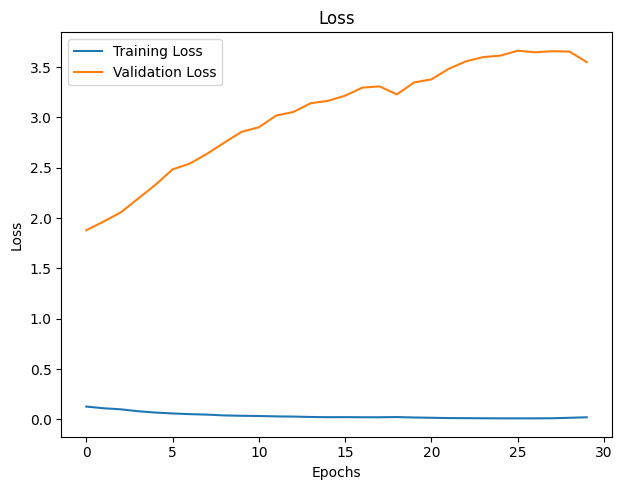

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plotting Loss and Accuracy
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the graphs
plot_loss_accuracy(history)

In [81]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = np.argmax(y_test, axis=-1)

# Flatten the predictions and true labels for metrics calculation
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, digits=4))

5/5 [==============================] - 0s 15ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.1655    0.2085    0.1845       446
           1     0.1702    0.1328    0.1492       482
           2     0.7829    0.7803    0.7816      2972

    accuracy                         0.6349      3900
   macro avg     0.3729    0.3739    0.3718      3900
weighted avg     0.6366    0.6349    0.6352      3900



Classification Report:
              precision    recall  f1-score   support

           B       0.16      0.21      0.18       445
           I       0.17      0.13      0.15       482
           O       0.78      0.78      0.78      2972

    accuracy                           0.63      3899
   macro avg       0.37      0.37      0.37      3899
weighted avg       0.64      0.63      0.64      3899

Confusion Matrix:
[[  92   51  302]
 [  77   64  341]
 [ 392  261 2319]]


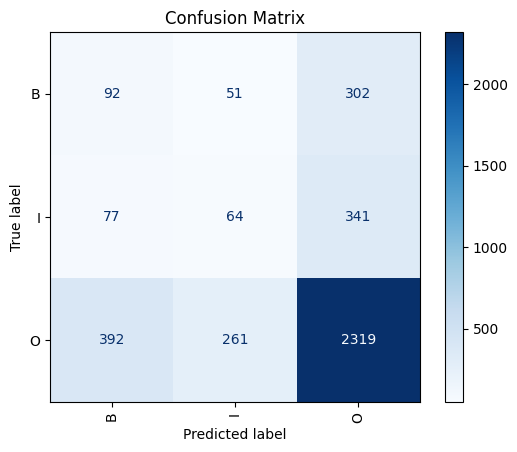

In [82]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def flatten_sequences(sequences):
    """
    Flattens a list of sequences into a single list.

    Args:
        sequences (list of list of str): List of sequences.

    Returns:
        flattened (list of str): Flattened sequence.
    """
    return [label for seq in sequences for label in seq]

# Flatten actual and predicted labels for comparison
y_true = flatten_sequences(test_labels)
y_pred = flatten_sequences(decoded_labels)

# Adjust the lengths of y_true and y_pred to match
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [84]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sample sentence to test
test_sentence = ["This", "paper", "aim", "to", "solve", "machine", "translation", "Tagging", "problem", "using", "neural", "networks"]

# Tokenize the sample sentence
token_ids = [tokenizer.word_index.get(token.lower(), 0) for token in test_sentence]  # Use .lower() for case-insensitivity

# Pad sequence to the same length as the training data
max_len = 30  # Ensure this matches the max token length used in training
token_ids_padded = pad_sequences([token_ids], maxlen=max_len, padding="post", truncating="post")

print("Tokenized and padded unseen data:", token_ids_padded)

# Predict using the trained model
predictions = model.predict(token_ids_padded)

# Decode predictions to class labels
predicted_labels = [label_encoder.inverse_transform([pred.argmax()])[0] for pred in predictions[0]]

# Combine original words with their predicted labels
word_label_pairs = [(word, label) for word, label in zip(test_sentence, predicted_labels[:len(test_sentence)])]

# Print results
print("\nOriginal Words with Predicted Labels:")
for word, label in word_label_pairs:
    print(f"{word}: {label}")

Tokenized and padded unseen data: [[  22  567 1118    8  876  142   42    0  148   87  281    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
1/1 [==============================] - 0s 60ms/step

Original Words with Predicted Labels:
This: O
paper: O
aim: O
to: O
solve: B
machine: I
translation: O
Tagging: B
problem: O
using: O
neural: O
networks: B
